In [294]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import math
import warnings
warnings.filterwarnings('ignore')

In [295]:
df = pd.read_csv('df_cian.csv')

In [296]:
df

,metro,price,rooms,floor,floors,square,turned
0,0,14629999,2,6,19,61.31,0
1,0,9799999,1,2,19,39.35,0
2,1,15441588,2,15,18,60.60,1
3,1,9350000,1,2,18,37.40,1
4,0,10239999,1,2,18,37.00,0
...,...,...,...,...,...,...,...
7915,0,5859341,1,2,12,35.00,0
7916,1,23324180,1,6,9,54.30,1
7917,0,8779520,1,10,13,37.35,1
7918,0,6449160,1,1,13,35.03,0


<AxesSubplot: >

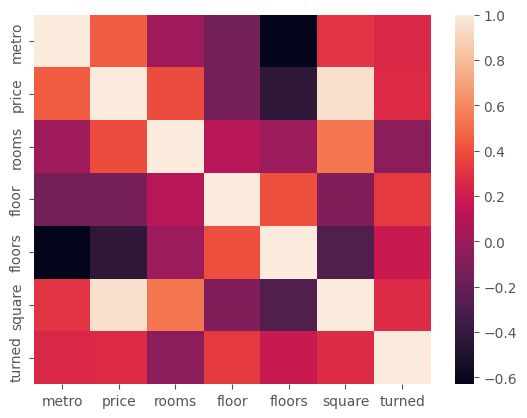

In [235]:
sns.heatmap(df.corr())

array([[<AxesSubplot: title={'center': 'metro'}>,
        <AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'rooms'}>],
       [<AxesSubplot: title={'center': 'floor'}>,
        <AxesSubplot: title={'center': 'floors'}>,
        <AxesSubplot: title={'center': 'square'}>],
       [<AxesSubplot: title={'center': 'turned'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

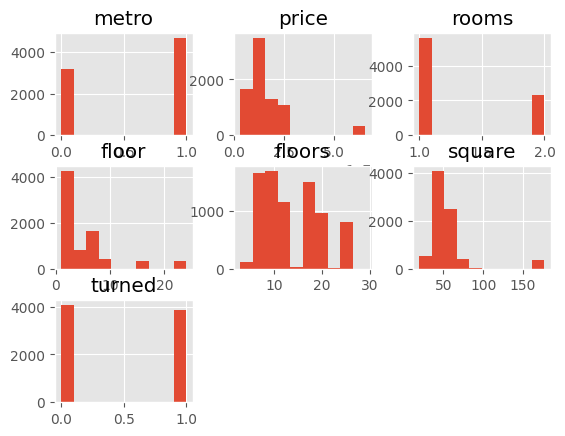

In [236]:
df.hist()

In [237]:
df.floor.max()

24

In [238]:
df.floor.min()

1

In [239]:
df.price.max()

65897100

In [240]:
df.price.min()

2944500

In [241]:
df.price.median()

14575500.0

In [242]:
df.square.max()

177.0

In [243]:
df.square.min()

19.63

In [244]:
df['floor_per'] = df['floor']/df['floors']

In [245]:
df['price_for_square'] = df['price']/df['square']

<AxesSubplot: >

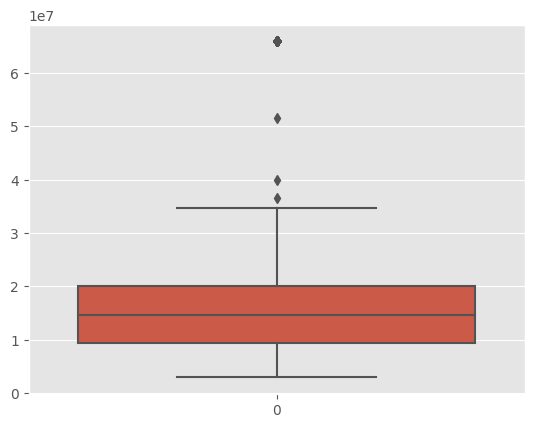

In [246]:
sns.boxplot(df['price'])

In [247]:
df = df[df['price'] < df['price'].quantile(0.95)]

<AxesSubplot: >

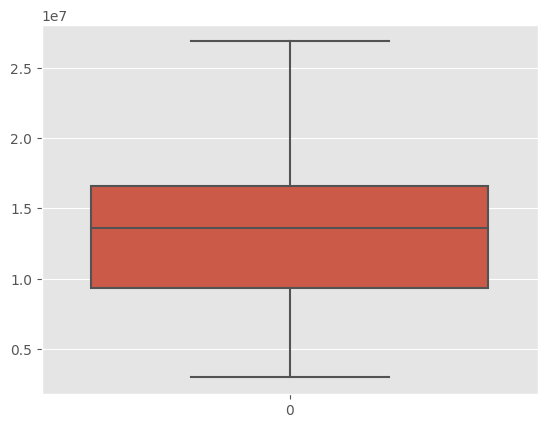

In [248]:
sns.boxplot(df['price'])

<AxesSubplot: >

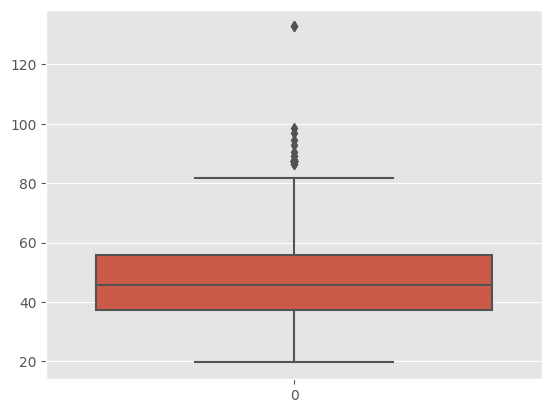

In [249]:
sns.boxplot(df['square'])

In [250]:
df = df[df['square'] < df['square'].quantile(0.95)]

<AxesSubplot: >

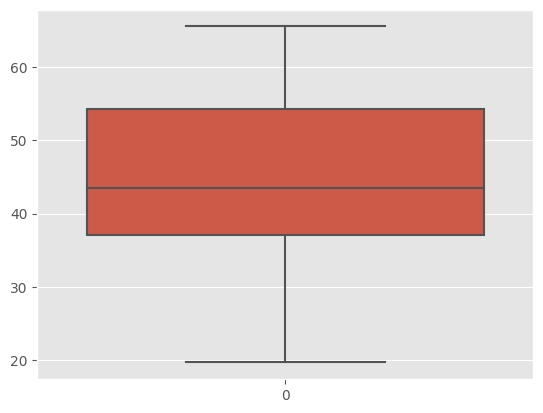

In [251]:
sns.boxplot(df['square'])

Цена явно зависит от квадратных метров

<AxesSubplot: xlabel='square', ylabel='price'>

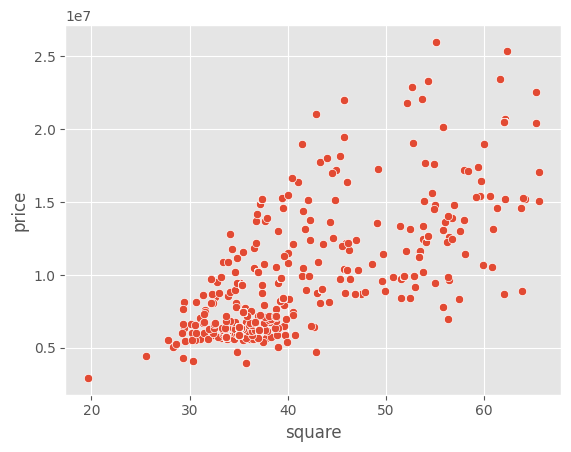

In [252]:
sns.scatterplot(data=df, x ='square', y='price')

In [253]:
df_for_pie = df.groupby('rooms', as_index=0).turned.mean()

Зависимость сдачи квартиры от количества комнат

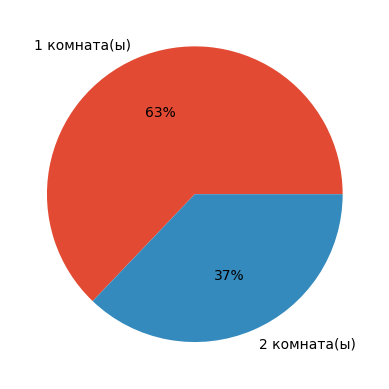

In [254]:
plt.pie(df_for_pie['turned'], labels=df_for_pie['rooms'].apply(lambda x: str(x)+' комната(ы)'), autopct='%.0f%%')
plt.show()

In [255]:
import pingouin as pg

In [256]:
expected, observed, stats = pg.chi2_independence(df, x='rooms',
                                                 y='turned')

In [257]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,177.873463,1.0,1.411707e-40,0.162092,1.0
1,cressie-read,0.666667,179.692380,1.0,5.657004e-41,0.162919,1.0
2,log-likelihood,0.000000,184.282811,1.0,5.628184e-42,0.164986,1.0
3,freeman-tukey,-0.500000,188.637208,1.0,6.306736e-43,0.166924,1.0
4,mod-log-likelihood,-1.000000,193.860926,1.0,4.566860e-44,0.169220,1.0
5,neyman,-2.000000,207.310718,1.0,5.304061e-47,0.174991,1.0


Однокомнатные сдают чаще чем двухкомнатные

<AxesSubplot: xlabel='metro', ylabel='price_for_square'>

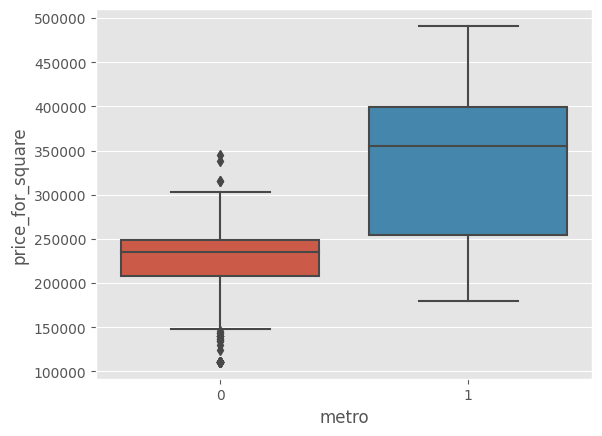

In [258]:
sns.boxplot(data=df, x='metro', y='price_for_square')

Наличие метро в шаговой доступности влияет на цену за квадратный метр

In [259]:
df_1 = df[df['metro'] == 1]
df_0 = df[df['metro'] == 0]

In [260]:
df_1.floor.mean()

5.071507760532151

In [261]:
df_0.floor.mean()

5.99146110056926

In [262]:
def get_bootstrap(
    data_column_1,  
    data_column_2,  
    boot_it=2000,  
    statistic=np.mean,  
    bootstrap_conf_level=0.95  
):
    boot_data = []
    for i in range(boot_it):  
        samples_1 = data_column_1.sample(
            len(data_column_1),
            replace=True  
        ).values

        samples_2 = data_column_2.sample(
            len(data_column_1),
            replace=True
        ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))  

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return p_value

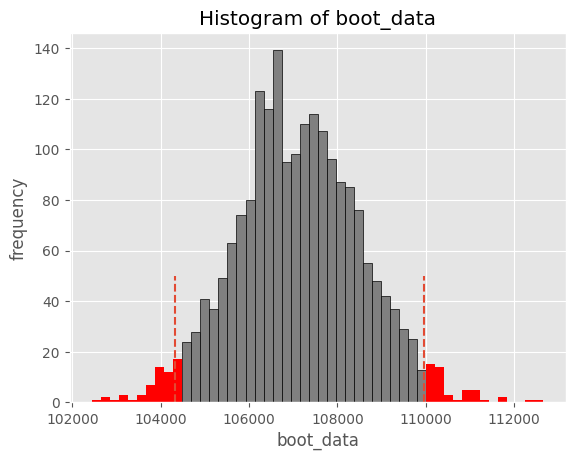

0.0

In [263]:
get_bootstrap(df_1['price_for_square'], df_0['price_for_square'])

Наличие метро в шаговой доступности определенно связано с ценой за квадратный метр

In [264]:
df

,metro,price,rooms,floor,floors,square,turned,floor_per,price_for_square
0,0,14629999,2,6,19,61.31,0,0.315789,238623.373022
1,0,9799999,1,2,19,39.35,0,0.105263,249046.988564
2,1,15441588,2,15,18,60.60,1,0.833333,254811.683168
3,1,9350000,1,2,18,37.40,1,0.111111,250000.000000
4,0,10239999,1,2,18,37.00,0,0.111111,276756.729730
...,...,...,...,...,...,...,...,...,...
7915,0,5859341,1,2,12,35.00,0,0.166667,167409.742857
7916,1,23324180,1,6,9,54.30,1,0.666667,429542.909761
7917,0,8779520,1,10,13,37.35,1,0.769231,235060.776439
7918,0,6449160,1,1,13,35.03,0,0.076923,184103.910933


In [265]:
df['is_first_or_second_floor'] = df['floor'].apply(lambda x: 1 if x == 1 or x==2 else 0)

In [266]:
df.groupby('is_first_or_second_floor', as_index=0).price_for_square.mean()

,is_first_or_second_floor,price_for_square
0,0,308086.151408
1,1,243915.664692


<AxesSubplot: xlabel='is_first_or_second_floor', ylabel='price_for_square'>

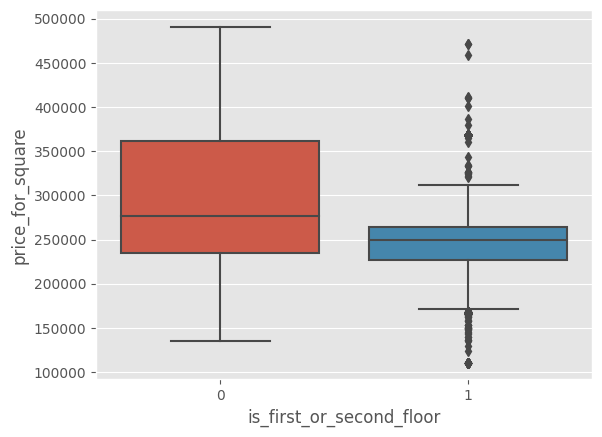

In [267]:
sns.boxplot(data=df, x='is_first_or_second_floor', y='price_for_square')

In [268]:
df_1 = df[df['is_first_or_second_floor'] == 1]
df_0 = df[df['is_first_or_second_floor'] == 0]

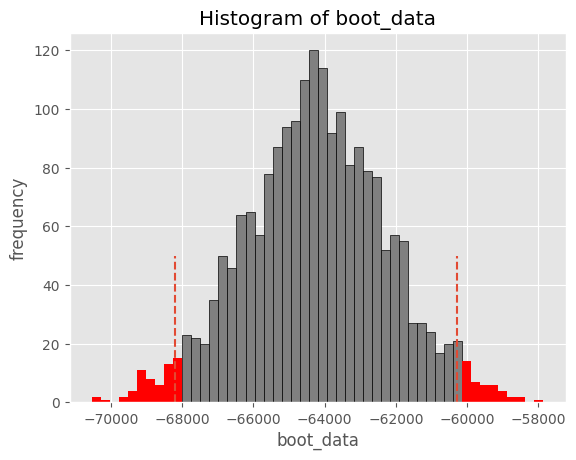

3.778587048996213e-232

In [269]:
get_bootstrap(df_1['price_for_square'], df_0['price_for_square'])

Стоимость квадратного метра первых 2-х этажей ниже

In [270]:
from sklearn import metrics
from scipy import stats
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [271]:
df.head(1)

,metro,price,rooms,floor,floors,square,turned,floor_per,price_for_square,is_first_or_second_floor
0,0,14629999,2,6,19,61.31,0,0.315789,238623.373022,0


In [272]:
X = df[['metro', 'rooms', 'is_first_or_second_floor', 'square', 'floors']]
y = df['price']

<AxesSubplot: >

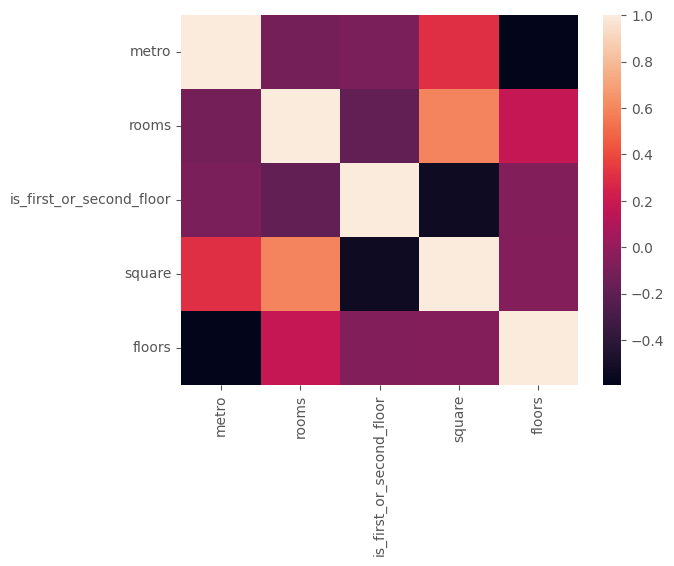

In [273]:
sns.heatmap(X.corr())

In [274]:
X = df[['metro', 'rooms', 'is_first_or_second_floor', 'square']]
y = df['price']

<AxesSubplot: >

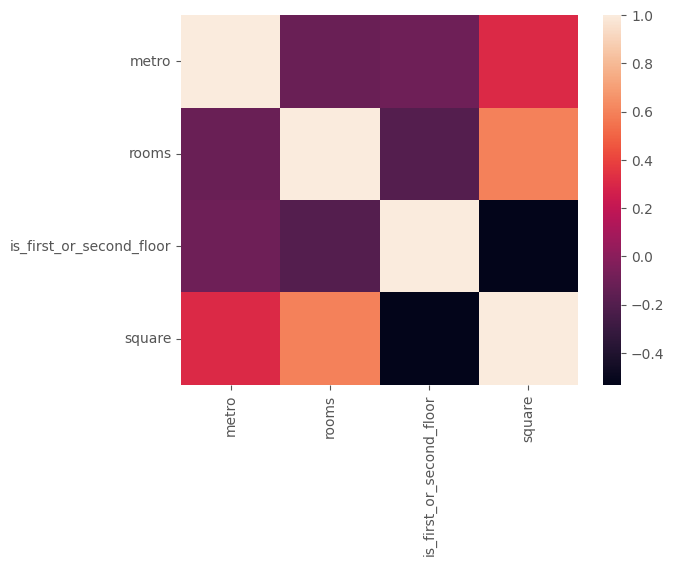

In [275]:
sns.heatmap(X.corr())

In [276]:
X = df[['metro', 'is_first_or_second_floor', 'square']]
y = df['price']

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42) 

<AxesSubplot: >

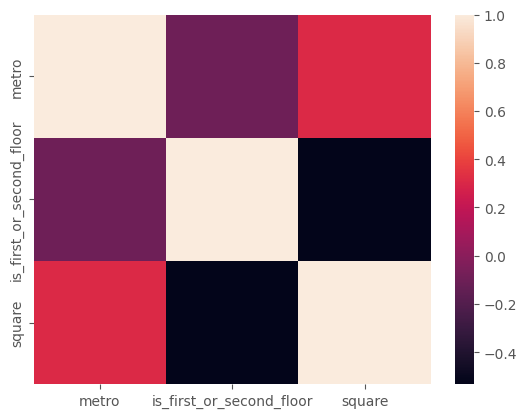

In [278]:
sns.heatmap(X.corr())

In [279]:
logreg = LogisticRegression()
dectrreg = DecisionTreeRegressor()
randfreg = RandomForestRegressor()

In [280]:
logreg.fit(X_train, y_train)
print('r2: ',cross_val_score(logreg, X, y, cv=5, scoring='r2'))
print('mae: ',cross_val_score(logreg, X, y, cv=5, scoring='neg_mean_absolute_error'))
print('mae: ',cross_val_score(logreg, X, y, cv=5, scoring='neg_mean_squared_error'))

r2:  [0.72671016 0.7321032  0.63630391 0.60899283 0.5567388 ]
mae:  [-1706793.66322009 -1695953.47932053 -2072445.85450517 -1952611.3042836
 -2212113.51329394]
mae:  [-7.15788767e+12 -7.03786976e+12 -9.53146002e+12 -1.03327324e+13
 -1.16940794e+13]


In [281]:
logreg.score(X_test, y_test)

0.3599212210733629

In [282]:
dectrreg.fit(X_train, y_train)
print('r2: ',cross_val_score(dectrreg, X, y, cv=5, scoring='r2'))
print('mae: ',cross_val_score(dectrreg, X, y, cv=5, scoring='neg_mean_absolute_error'))
print('mae: ',cross_val_score(dectrreg, X, y, cv=5, scoring='neg_mean_squared_error'))

r2:  [0.88437716 0.99999942 0.99999967 0.99983613 0.99999959]
mae:  [-6.44123903e+05 -5.36357748e+02 -4.10984945e+02 -2.31489311e+03
 -4.56212225e+02]
mae:  [-3.02169681e+12 -1.52557588e+07 -8.78104190e+06 -4.28093829e+09
 -1.07218198e+07]


In [283]:
dectrreg.score(X_test, y_test)

0.9865428715212297

In [284]:
randfreg.fit(X_train, y_train)
print('r2: ',cross_val_score(randfreg, X, y, cv=5, scoring='r2'))
print('mae: ',cross_val_score(randfreg, X, y, cv=5, scoring='neg_mean_absolute_error'))
print('mae: ',cross_val_score(randfreg, X, y, cv=5, scoring='neg_mean_squared_error'))

r2:  [0.885098   0.99999947 0.99999964 0.99992349 0.99999947]
mae:  [-6.41398908e+05 -4.99177624e+02 -3.64092955e+02 -2.09517949e+03
 -4.35391664e+02]
mae:  [-3.01492932e+12 -1.23973696e+07 -7.68133008e+06 -2.47826178e+09
 -8.35927894e+06]


In [285]:
randfreg.score(X_test, y_test)

0.9895943477701786

In [286]:
from sklearn.model_selection import RandomizedSearchCV

In [287]:
X

,metro,is_first_or_second_floor,square
0,0,0,61.31
1,0,1,39.35
2,1,0,60.60
3,1,1,37.40
4,0,1,37.00
...,...,...,...
7915,0,1,35.00
7916,1,0,54.30
7917,0,0,37.35
7918,0,1,35.03


In [288]:
dectrreg = DecisionTreeRegressor()
parameters_dectrreg = {
              "min_samples_split": [10, 20, 30, 40],
              "max_depth": [2, 4, 6, 8, 10],
              "min_samples_leaf": [20, 40, 50, 100],
              "max_leaf_nodes": [5, 20, 50, 100],
              }
rs = RandomizedSearchCV(dectrreg, 
                        parameters_dectrreg, 
                        n_iter = 50, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
dectrreg_2 = rs.best_estimator_
rs.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'min_samples_split': 10,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 100,
 'max_depth': 8}

In [289]:
dectrreg_2.score(X_test, y_test)

0.9810854637768409

In [290]:
print('r2: ',cross_val_score(dectrreg_2, X, y, cv=5, scoring='r2'))
print('mae: ',cross_val_score(dectrreg_2, X, y, cv=5, scoring='neg_mean_absolute_error'))
print('mae: ',cross_val_score(dectrreg_2, X, y, cv=5, scoring='neg_mean_squared_error'))

r2:  [0.88113792 0.99869857 0.99880703 0.99859067 0.99880956]
mae:  [-653423.41376314  -84313.33857538  -79231.86431725  -83901.74147835
  -79614.18870237]
mae:  [-3.10635126e+12 -3.41899193e+10 -3.13292420e+10 -3.68185149e+10
 -3.11791408e+10]


In [291]:
randfreg = RandomForestRegressor()
parameters_randfreg = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rs = RandomizedSearchCV(randfreg, 
                        parameters_randfreg, 
                        n_iter = 50, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
randfreg_2 = rs.best_estimator_
rs.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'bootstrap': True}

In [292]:
randfreg_2.score(X_test, y_test)

0.9896303743981283

In [293]:
print('r2: ',cross_val_score(randfreg_2, X, y, cv=5, scoring='r2'))
print('mae: ',cross_val_score(randfreg_2, X, y, cv=5, scoring='neg_mean_absolute_error'))
print('mae: ',cross_val_score(randfreg_2, X, y, cv=5, scoring='neg_mean_squared_error'))

r2:  [0.88502092 0.99999773 0.99999877 0.99998096 0.99999842]
mae:  [-643165.6373389    -1383.55528098   -1120.21051319   -2051.52361725
   -1135.46604021]
mae:  [-3.00943895e+12 -5.95327681e+07 -3.11557487e+07 -4.41365477e+08
 -3.86741933e+07]
